In [ ]:
## Imports ##

from llama_index.core.workflow import (
    Event,
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Context,
)
import random
from llama_index.core.workflow import draw_all_possible_flows
from llama_index.utils.workflow import draw_most_recent_execution
from llama_index.core.query_engine import RetrieverQueryEngine
from typing import Optional, List, Callable
from llama_index.utils.workflow import draw_all_possible_flows
from colorama import Fore, Back, Style
from llama_index.core.chat_engine import SimpleChatEngine

from pathlib import Path
import pymupdf
from llama_index.core import Document
from typing import List
import re
import re
from llama_index.core import Document
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.schema import TransformComponent
from llama_index.core.node_parser import (
    SentenceSplitter,
)

from llama_index.core.schema import BaseNode, TransformComponent
import copy
from llama_index.core.llms import ChatMessage

from llama_index.retrievers.bm25 import BM25Retriever
from llama_index.core.retrievers import BaseRetriever, VectorIndexRetriever
from llama_index.core.schema import NodeWithScore
from llama_index.core import VectorStoreIndex, QueryBundle
from llama_index.core.llms import ChatMessage
from llama_index.core.postprocessor import LLMRerank

from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from dotenv import load_dotenv
import os
from pathlib import Path
from llama_index.core import PromptTemplate
from llama_index.core import Settings

# Load settings file
load_dotenv()

In [74]:
# llama-index is based on asyncio
import nest_asyncio
nest_asyncio.apply()

In [75]:
# Load models to llamaindex from_defaults

MODELO_ORIGINAL_NAME = os.getenv("MODEL_AZURE_NAME")
MODELO_EMBEDDING = os.getenv("MODELO_EMBEDDING")
MODELO = os.getenv("MODELO")
KEY = os.getenv("KEY")
VERSION = os.getenv("VERSION")
ENDPOINT = os.getenv("ENDPOINT")
DATA_DIR = Path(os.getenv("DATA_DIR"))
EMBED_DIMENSION = os.getenv("EMBED_DIMENSION")

llm = AzureOpenAI(
    model=MODELO_ORIGINAL_NAME,
    deployment_name=MODELO,
    api_key=KEY,
    azure_endpoint=ENDPOINT,
    api_version=VERSION,
)

embed_model = AzureOpenAIEmbedding( 
    model="text-embedding-3-large",   # "text-embedding-3-large" "text-embedding-ada-002"
    deployment_name=MODELO_EMBEDDING,
    api_key=KEY,
    azure_endpoint=ENDPOINT,
    api_version=VERSION,
)

Settings.llm = llm
Settings.embed_model = embed_model

In [ ]:
class CustomDirectoryReader:
    """A Custom reader to load entire pdf as a Instance of llama-index Document()"""
    
    def __init__(self, data_path: str):
        self.path = data_path
        self.documents: List[Document] = []
        
        _files = []
        for path in Path(data_path).glob("*.pdf"):
            print(path)
            _files.append(path)
            
        self.files = _files

    def read_docs(self, **kwargs) -> List[Document]:
        for _file in self.files:
            with pymupdf.open(_file, **kwargs) as doc:  # open document
                
                text = chr(12).join([page.get_text() for page in doc])
                self.documents.append(
                    Document(text=text,
                            # metadata={"file_name":_file}
                             )
                             )
                
        return self.documents 
    
class CustomTransformation:
    def __call__(self, documents):
        transformed_documents = []
        for doc in documents:
            transformed_content = doc.get_content().lower()
            transformed_content = re.sub(r'\s+', ' ', transformed_content)
            transformed_content = re.sub(r'[^\w\s]', '', transformed_content)
            transformed_documents.append(Document(text=transformed_content, metadata=doc.metadata))
        return transformed_documents
 
class ConteXtualNodeParser(TransformComponent):
    """
    Generates contexts to each chunk of text
    This is the main functionality of CONTEXTUAL-RETRIEVAL
    """
    
    def __call__(self, nodes, doc,  **kwargs) -> List[BaseNode]:
        
        nodes_modified = []
        for node in nodes:
            new_node = copy.deepcopy(node)
            
            # main operations
            prompt_document = """<document>
                                {WHOLE_DOCUMENT}
                                </document>"""

            prompt_chunk = """Here is the chunk we want to situate within the whole document
                                <chunk>
                                {CHUNK_CONTENT}
                                </chunk>
                                Please give a short succinct in spanish context to situate this chunk within the overall document for the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else."""

            messages=[
                    ChatMessage(role="system", content="You are helpful AI Assitant."),
                    ChatMessage(
                        role="user",
                        content=[
                            {
                                "text": prompt_document.format(
                                    WHOLE_DOCUMENT=doc.text
                                ),
                                "type": "text",
                                "cache_control": {"type": "ephemeral"},
                            },
                            {
                                "text": prompt_chunk.format(CHUNK_CONTENT=node.text),
                                "type": "text",
                            },
                        ],
                    ),
                    ]

            
            result = str(
             llm.chat(
                messages,
                extra_headers={"anthropic-beta": "prompt-caching-2024-07-31"}))
            new_node.metadata["context"] = result
            new_node.text = result + node.text
            nodes_modified.append(new_node)
            
        return nodes_modified    
    
documents = CustomDirectoryReader(DATA_DIR).read_docs()
custom_transform = CustomTransformation()
documents = custom_transform(documents)

splitter = SentenceSplitter(
    chunk_size=1024,
    chunk_overlap=20,
)

for doc in documents:
    _nodes = splitter.get_nodes_from_documents([doc])
    parser = ConteXtualNodeParser()
    nodes = parser(doc=doc, nodes=_nodes)


In [81]:
def create_embedding_retriever(nodes_, similarity_top_k=2):
    """Function to create an embedding retriever for a list of nodes"""
    vector_index = VectorStoreIndex(nodes_)
    retriever = vector_index.as_retriever(similarity_top_k=similarity_top_k)
    return retriever


def create_bm25_retriever(nodes_, similarity_top_k=2):
    """Function to create a bm25 retriever for a list of nodes"""
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes_,
        similarity_top_k=similarity_top_k,
        #stemmer=Stemmer.Stemmer("spanish"),
        language="english",
    )
    return bm25_retriever

class EmbeddingBM25RerankerRetriever(BaseRetriever):
    """Custom retriever that uses both embedding and bm25 retrievers and reranker"""

    def __init__(
        self,
        vector_retriever: VectorIndexRetriever,
        bm25_retriever: BM25Retriever
    ) -> None:
        """Init params."""

        self._vector_retriever = vector_retriever
        self.bm25_retriever = bm25_retriever

        super().__init__()

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve nodes given query."""

        vector_nodes = self._vector_retriever.retrieve(query_bundle)
        bm25_nodes = self.bm25_retriever.retrieve(query_bundle)

        vector_nodes.extend(bm25_nodes)

        reranker = LLMRerank(
                    choice_batch_size=5,
                    top_n=5,
        )
        retrieved_nodes = reranker.postprocess_nodes(
            vector_nodes, query_bundle
        )
    
        return retrieved_nodes

In [82]:
embedding_retriever = create_embedding_retriever(
    nodes, similarity_top_k=5
)
bm25_retriever = create_bm25_retriever(
    nodes, similarity_top_k=5
)
embedding_bm25_retriever_rerank = EmbeddingBM25RerankerRetriever(
    embedding_retriever, bm25_retriever
)

In [154]:
REFLECTION_PROMPT = """

You are a helpful assistant that helps to generate new correct querys instead of an erroneus one to
make a correct answer.
    
    The erroneus query was {query}
    
    The bad answer was {response}

Perform query decomposition. Given a user question, break it down into distinct sub questions that
you need to answer in order to answer the original question.

If there are acronyms or words you are not familiar with, do not try to rephrase them.

"""


class RetrieveEvent(Event):
    query: str
    
class JudgeEvent(Event):
    query: str
    response: str
    
class InvalidEvent(Event):
    query: str
    response: str
    

class ReflectionWorkflow(Workflow):
    max_retries: int = 3
    
    @step(pass_context=True)     
    async def initialize(self, ctx: Context, ev: StartEvent) -> RetrieveEvent:
        
        llm = ev.get("llm")
        await ctx.set("llm", llm)
        
        index = ev.get("retriever")
        await ctx.set("retriever", index)
                
        query = ev.get("query")
        await ctx.set("query", query)
        
        return RetrieveEvent(query=ev.query)
    
    @step
    async def retrieve(
        self, ctx: Context, ev: RetrieveEvent | InvalidEvent
    ) -> StopEvent | JudgeEvent:
        current_retries = await ctx.get("retries", default=0)
        # we use a chat engine so it remembers previous interactions
        ctx.data["judge"] = SimpleChatEngine.from_defaults()
        
        if current_retries >= self.max_retries:
            return StopEvent(result="Max retries reached")
        else:
            await ctx.set("retries", current_retries + 1)
            
        if isinstance(ev, RetrieveEvent):
            query = ctx.data["query"]
            if not query:
                return StopEvent(result = "Please provide query")
            reflection_prompt = ""
            
            retriever = ctx.data["retriever"]            
            nodes = retriever.retrieve(ev.query)
            query_engine = RetrieverQueryEngine.from_args(retriever)
            response = query_engine.query(ev.query)
            
            print(response)
            return JudgeEvent(query = ev.query, response=str(response))
                 
        elif isinstance(ev, InvalidEvent):
            query = ev.query
            reflection_prompt = REFLECTION_PROMPT.format(
                query=ev.query, response=ev.response
            )
            
        
       
    @step     
    async def judge(self, ctx: Context, ev: JudgeEvent 
    ) -> StopEvent | InvalidEvent:
        
        
        response = ctx.data["judge"].chat(f"""
            A user has provided a query and a RAG strategie has been used
            to try to answer the query. Your job is to decide if the answer is 
            correct and answers everything the user has asked. The query was: {ev.query}
           
            And the response was: {ev.response}
           
            Please provide the number (1 or 2).
            1 if response is correct
            2 if response is incorrect
            
        """) 
                
        _response = int(str(response))
        if _response == 2:
            return InvalidEvent(query=ev.query, response=ev.response)
        else:
            return StopEvent(result=str(ev.response))

In [ ]:
w = ReflectionWorkflow(timeout=10, verbose=True)
result = await w.run(llm=llm, retriever=embedding_bm25_retriever_rerank, query="¿Cual son las clausulas del contrato de marco y anexos boost?")
print(result)


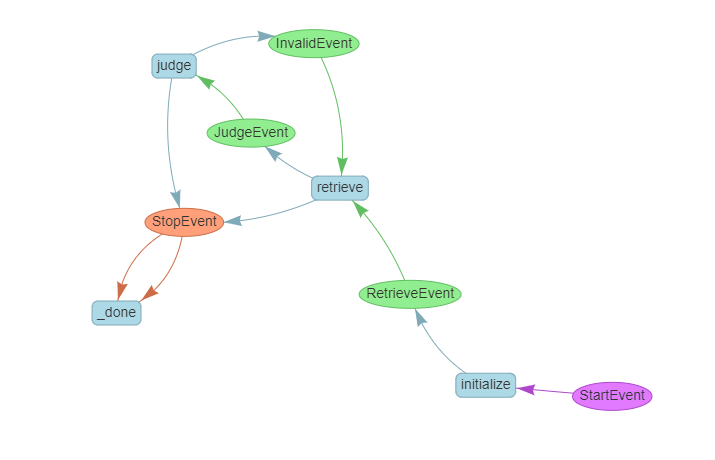

In [ ]:
draw_all_possible_flows(ReflectionWorkflow, filename="BaseWorkflowGRAPH.html")